# Bayesian LSTM via dropout

Some description

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
from energy_data import import_energy_data
from ts_utils import create_sliding_window
from sklearn.model_selection import TimeSeriesSplit

from models.lstm_encoder_decoder import lstm_seq2seq
from models.bayesian_lstm_dropout import BayesLSTMencoder

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

## Electricity data

We'll need two sets of data, for the training and pretraining steps

In [3]:
# we'll use the electricity data for this, import:
energy_df = import_energy_data()
print(energy_df.head())

train_split = 0.7
n_train = int(train_split * len(energy_df))
n_test = len(energy_df) - n_train

features = ['log_energy_consumption','day_of_week','hour_of_day']
feature_array = energy_df[features].values

# Fit Scaler only on Training features
scaler = StandardScaler()
scaler.fit(feature_array[:n_train])

target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train,0:1])

def inverse_transform(x):
    return np.exp(target_scaler.inverse_transform(x.reshape(-1, 1)))

# Transform on both Training and Test data
scaled_array = pd.DataFrame(scaler.transform(feature_array),
                            columns=features)

                                   date  day_of_week  hour_of_day  \
date                                                                
2016-01-11 17:00:00 2016-01-11 17:00:00            0           17   
2016-01-11 18:00:00 2016-01-11 18:00:00            0           18   
2016-01-11 19:00:00 2016-01-11 19:00:00            0           19   
2016-01-11 20:00:00 2016-01-11 20:00:00            0           20   
2016-01-11 21:00:00 2016-01-11 21:00:00            0           21   

                     log_energy_consumption  
date                                         
2016-01-11 17:00:00                4.007333  
2016-01-11 18:00:00                5.174265  
2016-01-11 19:00:00                5.155217  
2016-01-11 20:00:00                4.828314  
2016-01-11 21:00:00                4.637960  


In [4]:
print(scaled_array.head())

   log_energy_consumption  day_of_week  hour_of_day
0                0.216290          0.0     0.739130
1                0.596809          0.0     0.782609
2                0.590598          0.0     0.826087
3                0.484000          0.0     0.869565
4                0.421928          0.0     0.913043


## Training

Train LSTM encoder decoder -> train LSTM

### Pretraining

In [5]:
class ElectricityDatasetED(Dataset):
    
    def __init__(self,X,y):
        self.X,self.y = X,y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx].to(DEVICE),self.y[idx].to(DEVICE)

In [6]:
# pretraining data: only the time series
sequence_length = 24
output_size = 12
Xe, ye = create_sliding_window(pd.DataFrame(scaled_array.loc[:,'log_energy_consumption']), sequence_length,output_size=output_size)

Xe_train = Xe[:n_train]
ye_train = ye[:n_train]

Xe_test = Xe[n_train:]
ye_test = ye[n_train:]

Xe_train = torch.tensor(Xe_train).float()
ye_train = torch.tensor(ye_train).unsqueeze(2).float()
Xe_test = torch.tensor(Xe_test).float()

In [7]:
def train_and_evaluate(model,dl_train,dl_valid,n_epochs,optimizer, loss_fn):
    training_losses = np.full(n_epochs, np.nan)
    eval_losses = np.full(n_epochs, np.nan)
    with tqdm(total=n_epochs) as tr:
        for epoch in range(n_epochs):
            train_loss = model.train_single_epoch(dl_train, optimizer, loss_fn)
            eval_loss = model.evaluate(dl_valid, loss_fn)
            # loss for epoch 
            training_losses
            training_losses[epoch] = train_loss
            eval_losses[epoch] = eval_loss
            # progress bar 
            tr.set_postfix(eval_loss="{0:.5f}".format(eval_loss))
            tr.update()
    return training_losses,eval_losses

In [8]:
# nfolds = 3
# tscv = TimeSeriesSplit(n_splits=nfolds)
# learning_rate = 0.01
# n_epochs = 30
# hidden_size = 5
# loss_fn = nn.MSELoss()
# for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
#     # prep data
#     X_tr, y_tr = X_train[torch.LongTensor(train_index)],y_train[torch.LongTensor(train_index)]
#     X_v, y_v = X_train[torch.LongTensor(test_index)],y_train[torch.LongTensor(test_index)]
#     dl_train = DataLoader(ElectricityDataset(X_tr, y_tr),batch_size=5)
#     dl_valid = DataLoader(ElectricityDataset(X_v, y_v),batch_size=1)
#     # model
#     model = lstm_seq2seq(1, hidden_size)
#     optimizer = optim.Adam(model.parameters(), lr = learning_rate)
#     training_losses,eval_losses = train_and_evaluate(model,dl_train,dl_valid,n_epochs,optimizer, loss_fn)
#     plt.plot(training_losses,label="training",color="blue")
#     plt.plot(eval_losses,label="validation",color="red")
#     if fold == 0:
#         plt.legend()
# plt.show()

In [9]:
dl_train = DataLoader(ElectricityDatasetED(Xe_train, ye_train),batch_size=5)

In [10]:
n_epochs = 30
learning_rate = 0.01
hidden_size = 32
loss_fn = nn.MSELoss()
encoder_decoder = lstm_seq2seq(1, hidden_size).to(DEVICE)
optimizer = optim.Adam(encoder_decoder.parameters(), lr = learning_rate)
with tqdm(total=n_epochs) as tr:
    for epoch in range(n_epochs):
        encoder_decoder.train_single_epoch(dl_train, optimizer, loss_fn)
        tr.update()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [07:13<00:00, 14.44s/it]


### Training

In [11]:
class ElectricityDataset(Dataset):
    
    def __init__(self,X_encode,X_other,y):
        self.X_encode,self.X_other,self.y = X_encode,X_other,y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_encode[idx].to(DEVICE),self.X_other[idx].to(DEVICE),self.y[idx].to(DEVICE)

In [12]:
# training data: time series plut other stuff
Xo, y = scaled_array.loc[:,['day_of_week','hour_of_day']].values, scaled_array.loc[:,['log_energy_consumption']].values

Xo_train = Xo[:n_train]
y_train = y[:n_train]
Xo_train = Xo_train[sequence_length:(-output_size)]
y_train = y_train[sequence_length:(-output_size)]

Xo_test = Xo[n_train:]
y_test = y[n_train:]
Xo_test = Xo_test[sequence_length:(-output_size)]
y_test = y_test[sequence_length:(-output_size)]

Xo_train = torch.tensor(Xo_train).unsqueeze(1).float()
y_train = torch.tensor(y_train).unsqueeze(2).float()
Xo_test = torch.tensor(Xo_test).unsqueeze(1).float()

In [13]:
dl_train = DataLoader(ElectricityDataset(Xe_train,Xo_train,y_train),batch_size=5)

In [14]:
def train_encoder_bool(model, train = False):
    for name, param in model.named_parameters():
        if param.requires_grad & name.startswith("encoder"):
            param.requires_grad = train

In [15]:
n_epochs = 30
learning_rate = 0.01
hidden_size = 32
model = BayesLSTMencoder(encoder_decoder.encoder,2,10,1).to(DEVICE)
train_encoder_bool(model)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
with tqdm(total=n_epochs) as tr:
    for epoch in range(n_epochs):
        model.train_single_epoch(dl_train, optimizer, loss_fn)
        tr.update()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.95s/it]


## Inference

Predict on the test data

In [16]:
# inference - mean only
y_preds = []
for xe,xo in zip(Xe_test,Xo_test):
    y_ = model.inference(xe.to(DEVICE),xo.to(DEVICE))
    y_preds.append(y_.squeeze())

In [17]:
y_preds = np.array(y_preds)
y_tests = np.concatenate(y_test)
print("RMSE ",np.sqrt(np.mean((y_preds-y_tests)**2)))

RMSE  0.1639246355584475


In [19]:
print("RMSE (original scale)",np.sqrt(np.mean((inverse_transform(y_preds)-inverse_transform(y_tests))**2)))

RMSE (original scale) 67.98744026379488


Text(0.5, 1.0, 'Bayesian LSTM')

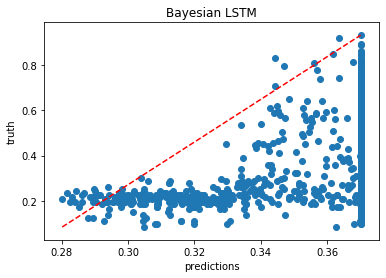

In [20]:
plt.plot(np.linspace(np.min(y_preds),np.max(y_preds)),np.linspace(np.min(y_tests),np.max(y_tests)),"r--")
plt.scatter(y_preds,y_tests)
plt.xlabel("predictions")
plt.ylabel("truth")
plt.title("Bayesian LSTM")

In [ ]:
# example predictions
plt.plot(inverse_transform(y_tests[0:72]))
plt.plot(inverse_transform(y_preds[0:72]))

In [ ]:
# inference - mean plus sd
def prediction_samples(Xe_test,Xo_test,B):
    y_preds_B = np.full((B,Xe_test.size(0)),np.nan)
    with tqdm(total=B) as tr:
        for b in range(B):
            y_preds = []
            for xe,xo in zip(Xe_test,Xo_test):
                y_ = model.inference(xe.to(DEVICE),xo.to(DEVICE),True)
                y_preds.append(y_.squeeze())
            y_preds_B[b,:] = np.array(y_preds)
            tr.update()
    return(y_preds_B)

In [ ]:
# example prediction intervals
B = 100
y_preds_sample = prediction_samples(Xe_test,Xo_test,B)
plt.plot(inverse_transform(y_tests[0:72]))
for b in range(B):
    plt.plot(inverse_transform(y_preds_sample[b,0:72]),"r-",alpha=0.1)
plt.show()